# Brownian Class

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class Brownian():

    #Constructor for Brownian class
    def __init__(self, M=500):
        # Initialize the Brownian motion class
        assert type(M) == int

        self.M = M
        self.board = np.zeros((M, M))

        # Set walls along the sides of the board
        self.board[0, :] = 1
        self.board[-1, :] = 1
        self.board[:, 0] = 1
        self.board[:, -1] = 1

        self.holes = []

        # Generate three random holes on the board
        for _ in range(3):
            hole_width = np.random.randint(1, M//4)
            hole_height = np.random.randint(1, M//4)
            hole_x = np.random.randint(1, M - hole_width - 1)
            hole_y = np.random.randint(1, M - hole_height - 1)

            # Set the corresponding area of the hole as 1 in the board
            self.board[hole_x:hole_x+hole_width, hole_y:hole_y+hole_height] = 1
            self.holes.append((hole_x, hole_y, hole_width, hole_height))


    # Generate a random walk that avoids holes
    def gen_random_walk(self, n_steps=100000):
        
        x = np.zeros(n_steps)
        y = np.zeros(n_steps)

        for i in range(n_steps):
            choice = np.random.randint(4)
            dx, dy = self._get_direction(choice)

            new_x = x[i-1] + dx
            new_y = y[i-1] + dy

            # Check if the next position is occupied by a hole
            while self._is_hole(new_x, new_y):
                choice = np.random.randint(4)
                dx, dy = self._get_direction(choice)
                new_x = x[i-1] + dx
                new_y = y[i-1] + dy

            x[i] = new_x
            y[i] = new_y

        return x, y
    

    # Get the direction based on the choice
    def _get_direction(self, choice):
        if choice == 0:
            return 0, 1  # Up
        elif choice == 1:
            return 0, -1  # Down
        elif choice == 2:
            return 1, 0  # Right
        else:
            return -1, 0  # Left
        

    # Check if the given position is occupied by a hole
    def _is_hole(self, x, y):
        for hole in self.holes:
            hole_x, hole_y, hole_width, hole_height = hole
            if hole_x <= x < hole_x + hole_width and hole_y <= y < hole_y + hole_height:
                return True
        return False


    # Draw the plot of the generated walk with random holes
    def draw_plot(self, walk):
        fig, ax = plt.subplots()
        ax.plot(walk[0], walk[1], color='#FF3F3F', label='Walk')

        for hole in self.holes:
            hole_x, hole_y, hole_width, hole_height = hole
            rect = Rectangle((hole_y, hole_x), hole_height, hole_width, facecolor='#2777B3', alpha=0.4)
            ax.add_patch(rect)
            rect_shadow = Rectangle((hole_y - 0.5, hole_x - 0.5), hole_height + 1, hole_width + 1,
                                    facecolor='#D3D3D3', alpha=0.3, hatch='/////')
            ax.add_patch(rect_shadow)

        plt.legend()
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Random Walk with Holes')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()



# Example Usage

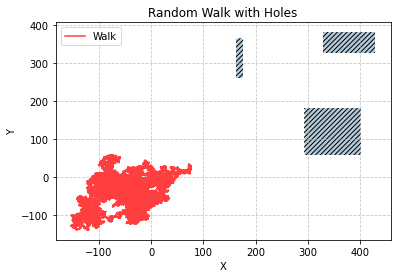

In [27]:
# Example usage
n_steps = 100000  # Number of steps in the random walk

brownian = Brownian()  # Initialize Brownian object with default board size
random_walk = brownian.gen_random_walk(n_steps)  # Generate a random walk

brownian.draw_plot(random_walk)  # Draw the plot